In [ ]:
!pip install -q kaggle torchvision scikit-learn matplotlib seaborn

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [ ]:
# Merge image folders
os.makedirs("HAM10000_images", exist_ok=True)
for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    for file in os.listdir(folder):
        shutil.copy(os.path.join(folder, file), os.path.join("HAM10000_images", file))

# Load metadata
df = pd.read_csv("HAM10000_metadata.csv")
df['label'] = df['dx'].apply(lambda x: 1 if x in ['mel', 'bkl', 'bcc', 'akiec'] else 0)


In [ ]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.loc[idx, 'image_id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Train/val/test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

def get_loaders(batch_size):
    return (
        DataLoader(SkinLesionDataset(train_df, "HAM10000_images", transform), batch_size=batch_size, shuffle=True),
        DataLoader(SkinLesionDataset(val_df, "HAM10000_images", transform), batch_size=batch_size),
        DataLoader(SkinLesionDataset(test_df, "HAM10000_images", transform), batch_size=batch_size)
    )


In [ ]:
#RESNET
def get_model(name='resnet', dropout=0.5):
    if name == 'resnet':
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, 1))
    elif name == 'googlenet':
        model = models.googlenet(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, 1))
    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}
    best_val_auc = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()

        model.eval()
        val_loss, val_correct, val_labels, val_scores = 0, 0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                val_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_labels.extend(labels.cpu().numpy())
                val_scores.extend(probs.cpu().numpy())

        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_auc = roc_auc_score(val_labels, val_scores)

        history['train_loss'].append(train_loss / len(train_loader.dataset))
        history['val_loss'].append(val_loss / len(val_loader.dataset))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

    return history

def plot_metrics(history, title=''):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

def evaluate_on_test(model, test_loader):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            prob = torch.sigmoid(outputs)
            pred = (prob > 0.5).float()
            probs.extend(prob.cpu().numpy())
            preds.extend(pred.cpu().numpy())
            labels.extend(label.numpy())

    acc = accuracy_score(labels, preds)
    auc_score = roc_auc_score(labels, probs)
    cm = confusion_matrix(labels, preds)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test AUC: {auc_score:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Cancer', 'Cancer'],
                yticklabels=['Non-Cancer', 'Cancer'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    precision, recall, _ = precision_recall_curve(labels, probs)
    plt.plot(recall, precision)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.grid(); plt.show()

    return acc, auc_score

def log_result(model_name, dropout, lr, batch_size, epochs, val_auc, test_acc, test_auc):
    results.append({
        'Model': model_name, 'Dropout': dropout, 'LR': lr, 'Batch Size': batch_size,
        'Epochs': epochs, 'Val AUC': val_auc, 'Test Accuracy': test_acc, 'Test AUC': test_auc
    })


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


Epoch 1/5 - Train Acc: 0.8531, Val Acc: 0.8731, AUC: 0.9497
Epoch 2/5 - Train Acc: 0.9124, Val Acc: 0.8951, AUC: 0.9569
Epoch 3/5 - Train Acc: 0.9488, Val Acc: 0.9021, AUC: 0.9596
Epoch 4/5 - Train Acc: 0.9697, Val Acc: 0.8821, AUC: 0.9541
Epoch 5/5 - Train Acc: 0.9769, Val Acc: 0.9021, AUC: 0.9560


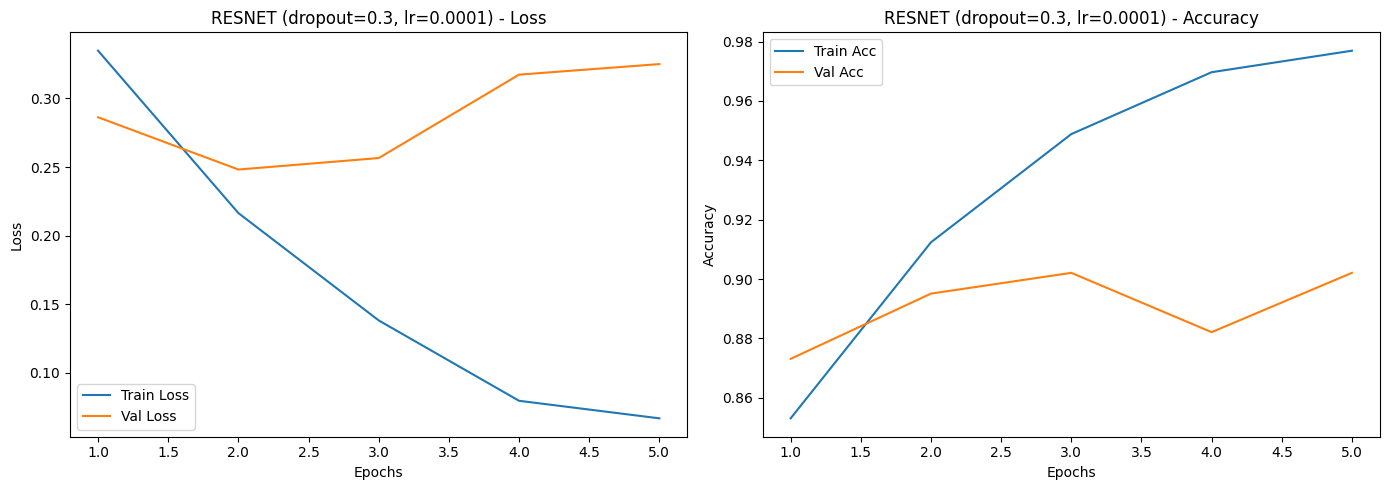

Test Accuracy: 0.9102
Test AUC: 0.9591


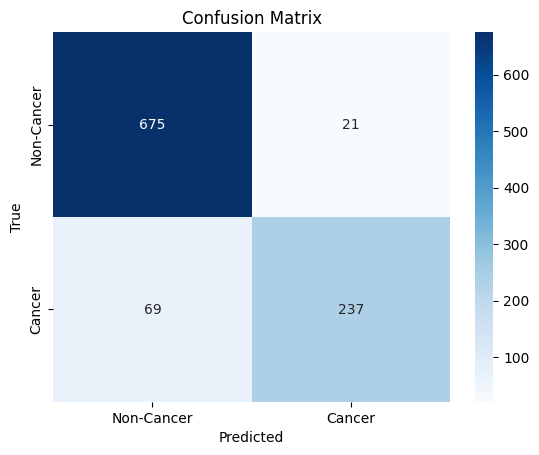

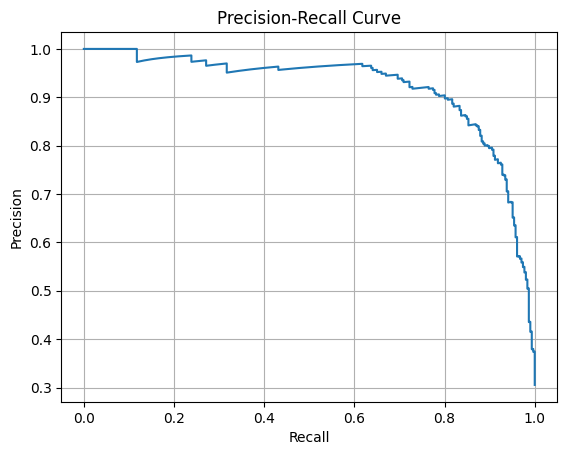

In [ ]:
# Set hyperparameters
model_name = 'resnet'  # or 'googlenet'
dropout = 0.3
lr = 1e-4
batch_size = 32
epochs = 5
optimizer_type = 'adam'

train_loader, val_loader, test_loader = get_loaders(batch_size)
model = get_model(model_name, dropout)

optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_type == 'adam' else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)
plot_metrics(history, f'{model_name.upper()} (dropout={dropout}, lr={lr})')

model.load_state_dict(torch.load("best_model.pth"))
test_acc, test_auc = evaluate_on_test(model, test_loader)
log_result(model_name, dropout, lr, batch_size, epochs, max(history['val_auc']), test_acc, test_auc)


In [ ]:
pd.DataFrame(results).sort_values(by='Test AUC', ascending=False)


,Model,Dropout,LR,Batch Size,Epochs,Val AUC,Test Accuracy,Test AUC
0,resnet,0.3,0.0001,32,5,0.959582,0.91018,0.959085



=== Experiment 1 ===
Model: resnet, LR: 0.0001, Dropout: 0.3, Batch: 16, Epochs: 5, Optimizer: adam


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Train Acc: 0.8397, Val Acc: 0.8811, AUC: 0.9499
Epoch 2/5 - Train Acc: 0.8879, Val Acc: 0.8771, AUC: 0.9388
Epoch 3/5 - Train Acc: 0.9185, Val Acc: 0.8821, AUC: 0.9453
Epoch 4/5 - Train Acc: 0.9456, Val Acc: 0.9041, AUC: 0.9589
Epoch 5/5 - Train Acc: 0.9672, Val Acc: 0.9081, AUC: 0.9567
Test Accuracy: 0.9072
Test AUC: 0.9592


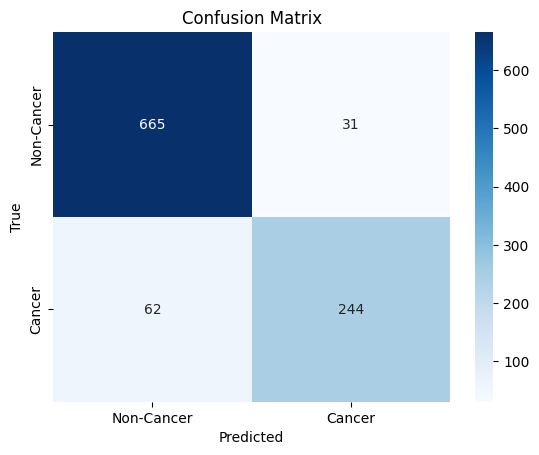

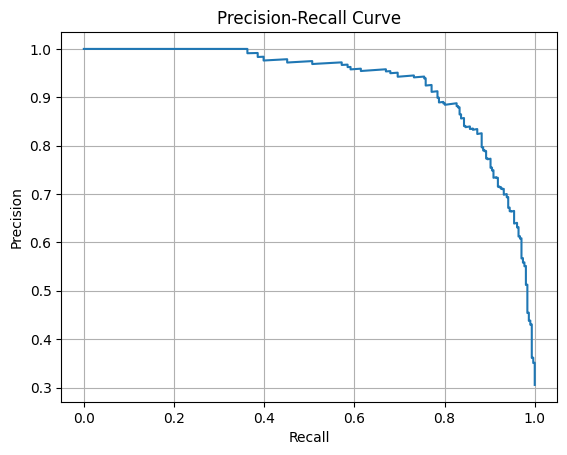


=== Experiment 2 ===
Model: resnet, LR: 0.0001, Dropout: 0.3, Batch: 16, Epochs: 5, Optimizer: sgd


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Train Acc: 0.7646, Val Acc: 0.8412, AUC: 0.9131
Epoch 2/5 - Train Acc: 0.8289, Val Acc: 0.8631, AUC: 0.9295
Epoch 3/5 - Train Acc: 0.8520, Val Acc: 0.8701, AUC: 0.9382
Epoch 4/5 - Train Acc: 0.8632, Val Acc: 0.8761, AUC: 0.9439
Epoch 5/5 - Train Acc: 0.8834, Val Acc: 0.8811, AUC: 0.9467
Test Accuracy: 0.8713
Test AUC: 0.9353


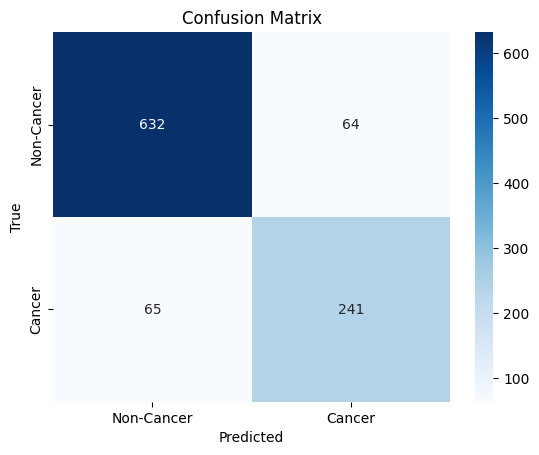

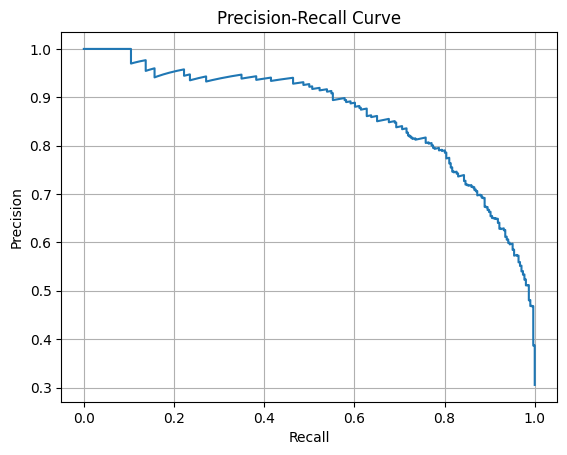


=== Experiment 3 ===
Model: resnet, LR: 0.0001, Dropout: 0.3, Batch: 16, Epochs: 10, Optimizer: adam


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Acc: 0.8346, Val Acc: 0.8851, AUC: 0.9429
Epoch 2/10 - Train Acc: 0.8878, Val Acc: 0.8811, AUC: 0.9538
Epoch 3/10 - Train Acc: 0.9179, Val Acc: 0.8971, AUC: 0.9573
Epoch 4/10 - Train Acc: 0.9478, Val Acc: 0.8921, AUC: 0.9507
Epoch 5/10 - Train Acc: 0.9628, Val Acc: 0.9121, AUC: 0.9651
Epoch 6/10 - Train Acc: 0.9724, Val Acc: 0.9121, AUC: 0.9660
Epoch 7/10 - Train Acc: 0.9772, Val Acc: 0.9021, AUC: 0.9606
Epoch 8/10 - Train Acc: 0.9865, Val Acc: 0.9091, AUC: 0.9632
Epoch 9/10 - Train Acc: 0.9820, Val Acc: 0.9041, AUC: 0.9579
Epoch 10/10 - Train Acc: 0.9891, Val Acc: 0.9191, AUC: 0.9633
Test Accuracy: 0.9012
Test AUC: 0.9496


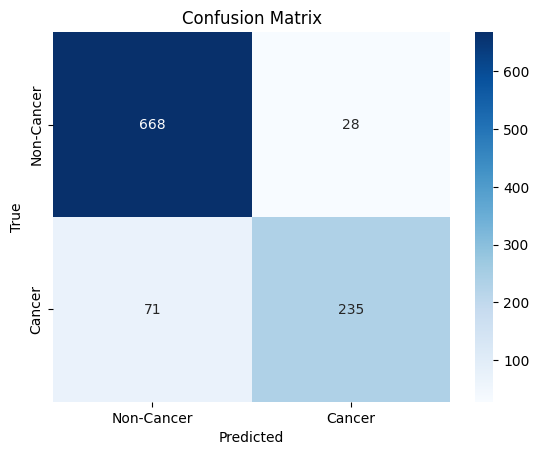

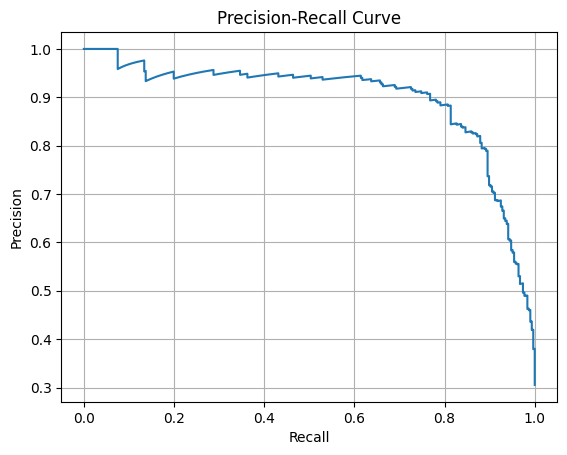


=== Experiment 4 ===
Model: resnet, LR: 0.0001, Dropout: 0.3, Batch: 16, Epochs: 10, Optimizer: sgd


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Acc: 0.7610, Val Acc: 0.8322, AUC: 0.9115
Epoch 2/10 - Train Acc: 0.8320, Val Acc: 0.8581, AUC: 0.9315
Epoch 3/10 - Train Acc: 0.8528, Val Acc: 0.8711, AUC: 0.9392
Epoch 4/10 - Train Acc: 0.8671, Val Acc: 0.8761, AUC: 0.9444
Epoch 5/10 - Train Acc: 0.8827, Val Acc: 0.8681, AUC: 0.9506
Epoch 6/10 - Train Acc: 0.8952, Val Acc: 0.8781, AUC: 0.9502
Epoch 7/10 - Train Acc: 0.9015, Val Acc: 0.8861, AUC: 0.9565
Epoch 8/10 - Train Acc: 0.9255, Val Acc: 0.8891, AUC: 0.9542
Epoch 9/10 - Train Acc: 0.9320, Val Acc: 0.9001, AUC: 0.9534
Epoch 10/10 - Train Acc: 0.9473, Val Acc: 0.8951, AUC: 0.9574
Test Accuracy: 0.9082
Test AUC: 0.9534


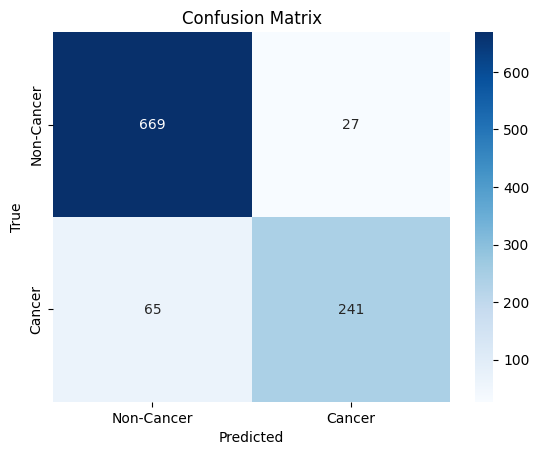

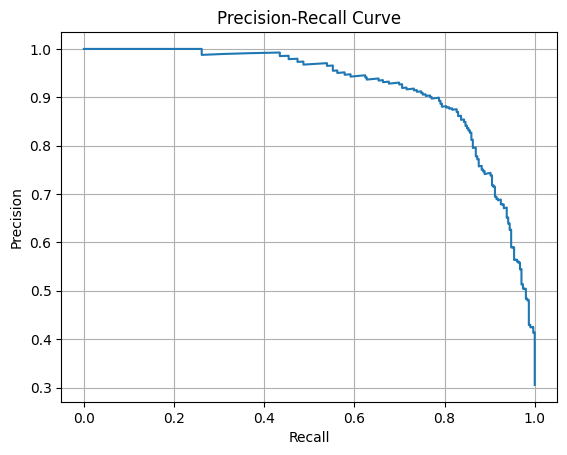


=== Experiment 5 ===
Model: resnet, LR: 0.0001, Dropout: 0.3, Batch: 32, Epochs: 5, Optimizer: adam


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
###
from itertools import product

# Define parameter grid
model_names = ['resnet', 'googlenet']
learning_rates = [1e-4, 1e-3]
dropouts = [0.3, 0.5]
batch_sizes = [16, 32]
epoch_options = [5, 10]
optimizers = ['adam', 'sgd']

# Run experiments
experiment_id = 1
for model_name, lr, dropout, batch_size, epochs, optimizer_type in product(
    model_names, learning_rates, dropouts, batch_sizes, epoch_options, optimizers
):
    print(f"\n=== Experiment {experiment_id} ===")
    print(f"Model: {model_name}, LR: {lr}, Dropout: {dropout}, Batch: {batch_size}, Epochs: {epochs}, Optimizer: {optimizer_type}")

    # Load data
    train_loader, val_loader, test_loader = get_loaders(batch_size)
    model = get_model(model_name, dropout)

    # Set optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_type == 'adam' else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.BCEWithLogitsLoss()

    # Train and evaluate
    history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)
    model.load_state_dict(torch.load("best_model.pth"))
    test_acc, test_auc = evaluate_on_test(model, test_loader)

    # Log result
    log_result(model_name, dropout, lr, batch_size, epochs, max(history['val_auc']), test_acc, test_auc)
    experiment_id += 1

# Show summary table
df_results = pd.DataFrame(results).sort_values(by='Test AUC', ascending=False)
print("\n=== Experiment Summary ===")
display(df_results)

In [ ]:
#GOOGLE NET
def get_model(name='googlenet', dropout=0.5):
    if name == 'resnet':
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, 1))
    elif name == 'googlenet':
        model = models.googlenet(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_features, 1))
    return model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}
    best_val_auc = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()

        model.eval()
        val_loss, val_correct, val_labels, val_scores = 0, 0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                val_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_labels.extend(labels.cpu().numpy())
                val_scores.extend(probs.cpu().numpy())

        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_auc = roc_auc_score(val_labels, val_scores)

        history['train_loss'].append(train_loss / len(train_loader.dataset))
        history['val_loss'].append(val_loss / len(val_loader.dataset))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

    return history

def plot_metrics(history, title=''):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

def evaluate_on_test(model, test_loader):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            prob = torch.sigmoid(outputs)
            pred = (prob > 0.5).float()
            probs.extend(prob.cpu().numpy())
            preds.extend(pred.cpu().numpy())
            labels.extend(label.numpy())

    acc = accuracy_score(labels, preds)
    auc_score = roc_auc_score(labels, probs)
    cm = confusion_matrix(labels, preds)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test AUC: {auc_score:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Cancer', 'Cancer'],
                yticklabels=['Non-Cancer', 'Cancer'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    precision, recall, _ = precision_recall_curve(labels, probs)
    plt.plot(recall, precision)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.grid(); plt.show()

    return acc, auc_score

def log_result(model_name, dropout, lr, batch_size, epochs, val_auc, test_acc, test_auc):
    results.append({
        'Model': model_name, 'Dropout': dropout, 'LR': lr, 'Batch Size': batch_size,
        'Epochs': epochs, 'Val AUC': val_auc, 'Test Accuracy': test_acc, 'Test AUC': test_auc
    })


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 97.0MB/s]


Epoch 1/5 - Train Acc: 0.8339, Val Acc: 0.8731, AUC: 0.9422
Epoch 2/5 - Train Acc: 0.9135, Val Acc: 0.8771, AUC: 0.9484
Epoch 3/5 - Train Acc: 0.9586, Val Acc: 0.8881, AUC: 0.9538
Epoch 4/5 - Train Acc: 0.9807, Val Acc: 0.8791, AUC: 0.9475
Epoch 5/5 - Train Acc: 0.9876, Val Acc: 0.9001, AUC: 0.9596


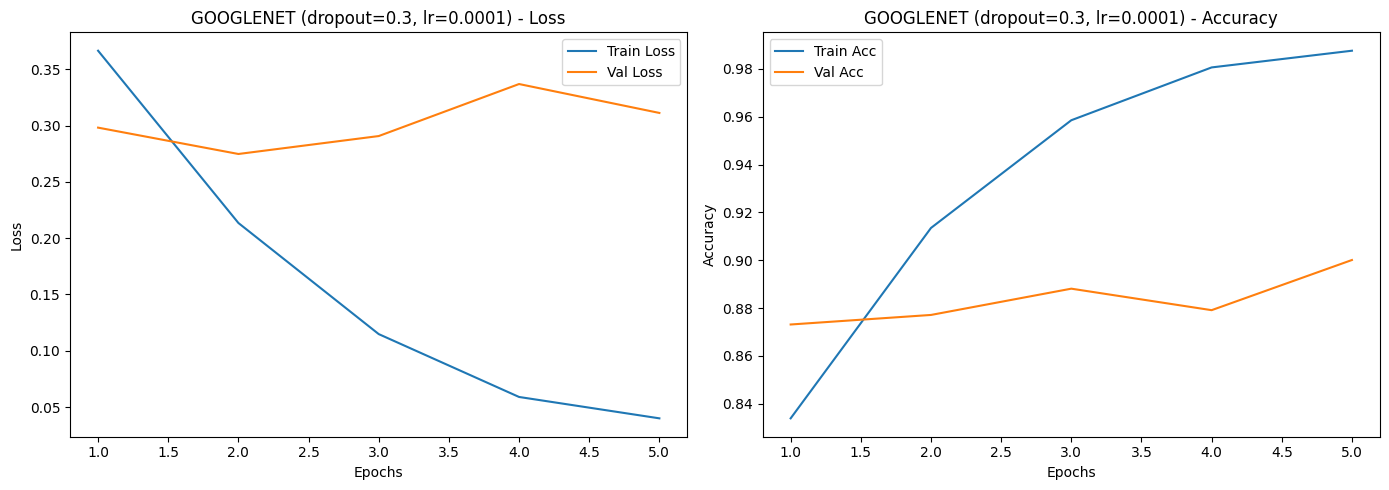

Test Accuracy: 0.8962
Test AUC: 0.9504


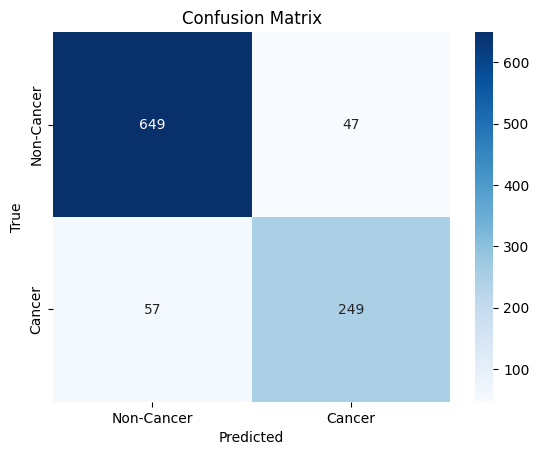

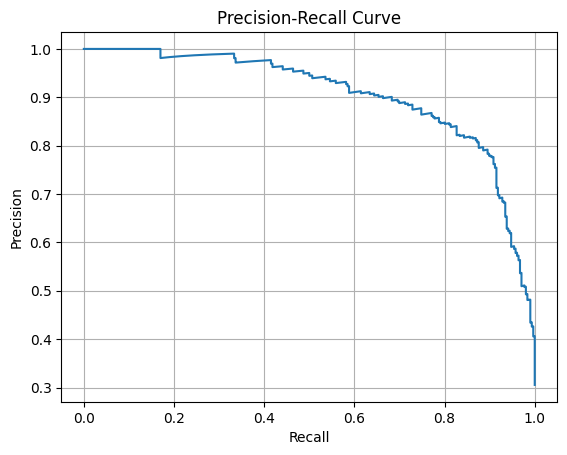

In [ ]:
# Set hyperparameters
model_name = 'googlenet'
dropout = 0.3
lr = 1e-4
batch_size = 32
epochs = 5
optimizer_type = 'adam'

train_loader, val_loader, test_loader = get_loaders(batch_size)
model = get_model(model_name, dropout)

optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_type == 'adam' else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)
plot_metrics(history, f'{model_name.upper()} (dropout={dropout}, lr={lr})')

model.load_state_dict(torch.load("best_model.pth"))
test_acc, test_auc = evaluate_on_test(model, test_loader)
log_result(model_name, dropout, lr, batch_size, epochs, max(history['val_auc']), test_acc, test_auc)
